<a href="https://colab.research.google.com/github/RoetGer/generalized-t-process-regression/blob/main/gen_t_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install gpflow

     |████████████████████████████████| 276kB 7.7MB/s 


In [ ]:
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

plt.rcParams["figure.figsize"] = (12, 8)

tf.__version__

'2.5.0'

In [ ]:
df = 3.
loc = tf.Variable([1., 2., 3.])
scale = [[ 0.6,  0. ,  0. ],
         [ 0.2,  0.5,  0. ],
         [ 0.1, -0.3,  0.4]]
scale = tf.linalg.LinearOperatorLowerTriangular(scale)

mvt = tfd.MultivariateStudentTLinearOperator(
    df=df,
    loc=loc,
    scale=scale)

In [ ]:
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    density = mvt.prob([0., 0., 0.])
  gradient = inner_tape.gradient(density, mvt.trainable_variables[0])

outer_tape.jacobian(gradient, mvt.trainable_variables[0])

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 6.9320464e-07, -7.5581365e-06, -9.2025548e-06],
       [-7.5581352e-06,  1.9834491e-05,  2.5120040e-05],
       [-9.2025539e-06,  2.5120042e-05,  2.7110138e-05]], dtype=float32)>

In [ ]:
mvt.trainable_variables

(<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>,)

In [ ]:
loc.shape

TensorShape([3])

### GPflow - Binary Classification

Foundation taken from [GPflow binary classification model](https://gpflow.readthedocs.io/en/master/notebooks/basics/classification.html)

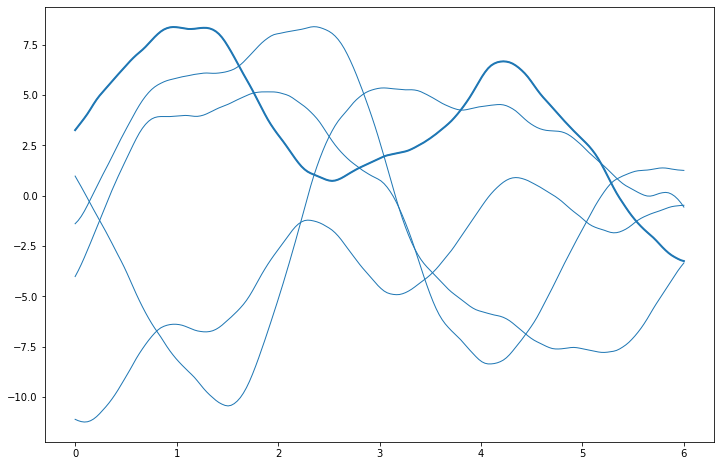

In [ ]:
# build the kernel and covariance matrix
k = gpflow.kernels.Matern52(variance=20.0)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)

L = np.linalg.cholesky(K)
f_grid = np.dot(L, rng.randn(200, 5))
plt.plot(x_grid, f_grid, "C0", linewidth=1)
_ = plt.plot(x_grid, f_grid[:, 1], "C0", linewidth=2)

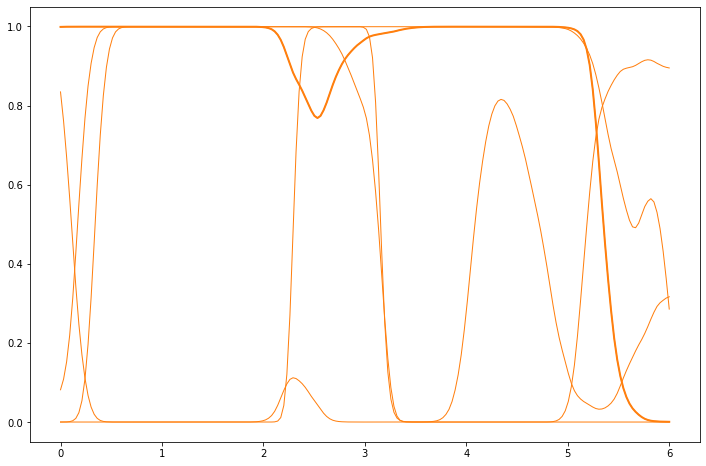

In [ ]:
def invlink(f):
    # By default, standard normal CDF is used as link function, but 
    # any other function can be used as well, just set invlink argument
    # of Bernoulli()
    return gpflow.likelihoods.Bernoulli().invlink(f).numpy()


p_grid = invlink(f_grid)
plt.plot(x_grid, p_grid, "C1", linewidth=1)
_ = plt.plot(x_grid, p_grid[:, 1], "C1", linewidth=2)

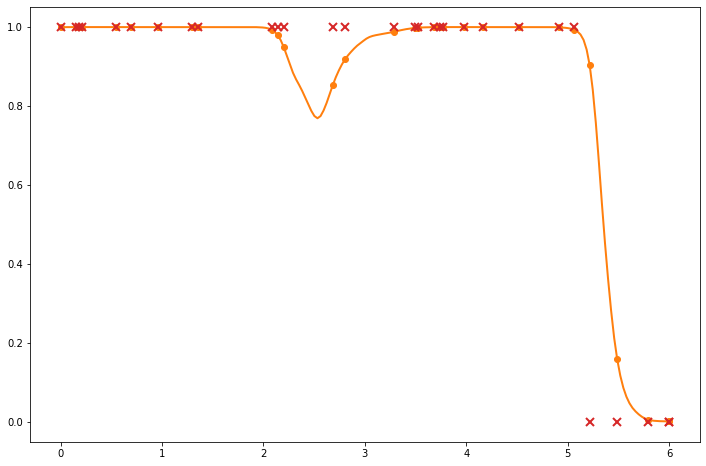

In [ ]:
# Select some input locations
ind = rng.randint(0, 200, (30,))
X_gen = x_grid[ind]

# evaluate probability and get Bernoulli draws
p = p_grid[ind, 1:2]
Y_gen = rng.binomial(1, p)

# plot
plt.plot(x_grid, p_grid[:, 1], "C1", linewidth=2)
plt.plot(X_gen, p, "C1o", ms=6)
_ = plt.plot(X_gen, Y_gen, "C3x", ms=8, mew=2)

In [ ]:
m = gpflow.models.VGP(
    (X_gen, Y_gen), likelihood=gpflow.likelihoods.Bernoulli(), kernel=gpflow.kernels.Matern52()
)

opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)

      fun: 5.921130177394291
 hess_inv: <497x497 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.78253795e-04, -1.61809166e-06,  7.97288934e-05, -2.56457370e-05,
       -3.19435981e-04, -9.77303768e-05,  3.65503836e-06, -3.55404475e-05,
        1.51691560e-06,  2.60414254e-06, -5.66910904e-07,  6.83518424e-07,
       -4.84583134e-06, -8.26329395e-07, -7.74970114e-06,  6.64908570e-06,
       -2.58952853e-07, -1.15593266e-05, -4.40631564e-07,  4.90943344e-07,
       -5.01536929e-09, -2.33588387e-09, -2.40253319e-06,  1.37008530e-07,
       -3.01552016e-07, -3.93965023e-07, -2.99033797e-08, -3.87416728e-08,
       -3.92586551e-08,  2.05379648e-08,  2.92843059e-06, -8.10135283e-08,
       -8.38028936e-08,  6.45942925e-16,  4.92766267e-11,  3.41825071e-15,
        5.14826996e-14, -3.38859041e-13,  1.52259895e-13,  9.40644512e-09,
       -2.80741643e-09,  6.83393397e-09,  5.31380897e-16, -2.47080565e-11,
        5.19857243e-13,  4.81490492e-09, -2.39469898e-08, -7.80634456e-10,


In [ ]:
m.training_loss()

<tf.Tensor: shape=(), dtype=float64, numpy=5.921130177394292>

In [ ]:
with tf.GradientTape() as tape:
  mll = m.maximum_log_likelihood_objective()

tape.jacobian(mll, m.trainable_variables)

In [ ]:
obs_dist = gpflow.likelihoods.Bernoulli(invlink=tf.math.sigmoid)

??obs_dist.predict_log_density

In [ ]:
obs_dist.log_prob(f_grid[:30,:1], Y_gen)

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([-1.61587877e+00, -1.48984477e+00, -1.33196346e+00, -3.79287935e-01,
       -4.79049744e-01, -7.88255854e-01, -6.32315490e-01, -5.01419843e-01,
       -3.91492380e-01, -3.03863486e-01, -2.35978500e-01, -1.81045085e-01,
       -1.36544524e-01, -2.32998985e+00, -7.63898726e-02, -5.71398647e-02,
       -4.30555024e-02, -3.25834221e-02, -2.46946565e-02, -3.98901426e+00,
       -1.42630033e-02, -1.10535643e-02, -8.75049693e-03, -7.11412427e-03,
       -5.93139030e-03, -5.07594011e-03, -4.47273717e-03, -4.04727220e-03,
       -5.59281770e+00, -3.47115426e-03])>

### GPC Laplace Approach

In [ ]:
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

plt.rcParams["figure.figsize"] = (12, 8)

tf.__version__

PI = tf.constant(np.pi, dtype=tf.float32)
obs_dist = gpflow.likelihoods.Bernoulli(invlink=tf.math.sigmoid)

def gpc_posterior(f, y, K):
  pad_K = K + 10e-5*tf.eye(K.shape[0])
  chol_K = tf.linalg.cholesky(pad_K)
  fK = tf.linalg.cholesky_solve(chol_K, f)
  nobs = f.shape[0]

  ll = (
    tf.reduce_sum(obs_dist.log_prob(f, y))
    - 0.5*tf.matmul(fK, fK, transpose_a=True)
    - tf.math.log(tf.reduce_sum(tf.linalg.diag_part(chol_K)))
    - 0.5*nobs*tf.math.log(2*PI)
  )

  return ll

def compute_posterior_covariance(K, w):
  sqrt_w = tf.sqrt(w)
  sqrt_w_t = tf.reshape(sqrt_w, shape=(-1, 1))

  K_sqrt_w = tf.multiply(K, sqrt_w)
  B = tf.eye(K.shape[0]) + tf.multiply(sqrt_w_t, K_sqrt_w)
  
  chol_B = tf.linalg.cholesky(B)
  K_sqrt_w_t = tf.transpose(K_sqrt_w)
  inv_sqrt_B_sqrt_w_K = tf.linalg.cholesky_solve(chol_B, K_sqrt_w_t)

  cov_mat = K - tf.matmul(
      inv_sqrt_B_sqrt_w_K, inv_sqrt_B_sqrt_w_K, transpose_a=True)
  
  return cov_mat

def compute_hess_vec_obs_ll(f, y):
  prod_vector = tf.repeat(1., repeats=f.shape[0])
  prod_vector = tf.reshape(prod_vector, shape=(-1,1))

  with tf.autodiff.ForwardAccumulator(
      f, prod_vector) as acc:
    with tf.GradientTape() as tape:
      obs_ll = tf.reduce_sum(obs_dist.log_prob(f, y))
    grad_obs_ll = tape.gradient(obs_ll, f)

  hess_vec = acc.jvp(grad_obs_ll)
  return tf.squeeze(hess_vec)

def compute_marginal_ll(f, y, K, hess_diag):
  sqrt_w = tf.sqrt(-hess_diag)
  sqrt_w_t = tf.reshape(sqrt_w, shape=(-1, 1))

  K_sqrt_w = tf.multiply(K, sqrt_w)
  B = tf.eye(K.shape[0]) + tf.multiply(sqrt_w_t, K_sqrt_w)
  chol_B = tf.linalg.cholesky(B)

  chol_K = tf.linalg.cholesky(K  + 10e-5*tf.eye(K.shape[0]))
  inv_chol_K_f = tf.linalg.cholesky_solve(chol_K, f)

  mll = (
      - 0.5*tf.tensordot(inv_chol_K_f, inv_chol_K_f, axes=(0, 0))
      + tf.reduce_sum(obs_dist.log_prob(f, y))
      - tf.reduce_sum(tf.math.log(tf.linalg.diag_part(chol_B)))
  )
  
  return mll

k = gpflow.kernels.SquaredExponential(lengthscales=1, variance=2.)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)

L = np.linalg.cholesky(K + 10e-6*np.eye(K.shape[0]))
f = np.dot(L, rng.randn(200, 1))
f = tf.cast(f, tf.float32)

pvals = obs_dist.invlink(f)
y = tf.cast(rng.binomial(1, pvals), tf.int32)

ModuleNotFoundError: ignored

In [ ]:
K = tf.cast(k(x_grid), tf.float32)
f = tf.Variable(f)
gpc_posterior(f, y, K)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-90782.42]], dtype=float32)>

In [ ]:
### Optimize posterior
from gpflow.optimizers import NaturalGradient
from gpflow.optimizers import Scipy

def get_gradients():
  with tf.GradientTape() as tape:
    ngpc = -gpc_posterior(f, y, K)
    nmll = -compute_marginal_ll(f, y, tf.cast(k(x_grid), tf.float32), hess_diag)
  tape.gradient()

opt = Scipy()

f = tf.Variable(f)

x_grid_tf = tf.constant(x_grid, dtype=tf.float64)

neg_post = [-gpc_posterior(f, y, K)]
hess_diag = compute_hess_vec_obs_ll(f, y)
marg_ll = [-compute_marginal_ll(f, y, tf.cast(k(x_grid), tf.float32), hess_diag)]

for i in range(10):
  #K = tf.cast(k(x_grid_tf), dtype=tf.float32)
  K = tf.cast(k(x_grid), tf.float32)
  opt_res = opt.minimize(lambda: -gpc_posterior(f, y, K), [f])
  neg_post.append(opt_res.fun)
  
  hess_diag = compute_hess_vec_obs_ll(f, y)
  print(i, tf.reduce_mean(hess_diag))
  opt_res = opt.minimize(
      lambda: -compute_marginal_ll(f, y, tf.cast(k(x_grid_tf), tf.float32), hess_diag), 
      k.trainable_variables)
  marg_ll.append(opt_res.fun)
  

0 tf.Tensor(-0.20540395, shape=(), dtype=float32)
1 tf.Tensor(-0.20540401, shape=(), dtype=float32)
2 tf.Tensor(-0.20540398, shape=(), dtype=float32)
3 tf.Tensor(-0.20540401, shape=(), dtype=float32)
4 tf.Tensor(-0.20540403, shape=(), dtype=float32)
5 tf.Tensor(-0.20540409, shape=(), dtype=float32)
6 tf.Tensor(-0.20540413, shape=(), dtype=float32)
7 tf.Tensor(-0.2054042, shape=(), dtype=float32)
8 tf.Tensor(-0.2054042, shape=(), dtype=float32)
9 tf.Tensor(-0.20540422, shape=(), dtype=float32)


In [ ]:
neg_post

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[90782.42]], dtype=float32)>,
 array([[314.97271729]]),
 array([[315.68981934]]),
 array([[315.66015625]]),
 array([[315.64770508]]),
 array([[315.63366699]]),
 array([[315.6048584]]),
 array([[315.56652832]]),
 array([[315.46252441]]),
 array([[315.4788208]]),
 array([[315.51574707]])]

In [ ]:
opt_res

      fun: array([[133.93280029]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.01119485, 0.00162611])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 22
      nit: 10
   status: 0
  success: True
        x: array([ 0.19593529, -0.94261868])

In [ ]:
with tf.GradientTape() as tape:
  ngpc = -gpc_posterior(f, y, K)
  nmll = -compute_marginal_ll(f, y, tf.cast(k(x_grid), tf.float32), hess_diag)
tape.gradient(nmll, [f, k.trainable_variables])

[<tf.Tensor: shape=(200, 1), dtype=float32, numpy=
 array([[ -772.5556   ],
        [ -201.0639   ],
        [  213.2083   ],
        [  153.32002  ],
        [  545.0853   ],
        [  363.60873  ],
        [  390.21664  ],
        [ -459.41174  ],
        [  265.6429   ],
        [ -156.199    ],
        [  263.83395  ],
        [ -605.73224  ],
        [   65.227234 ],
        [  950.0456   ],
        [  -54.100628 ],
        [ -649.5994   ],
        [  155.39876  ],
        [  493.7262   ],
        [-1242.3228   ],
        [  -36.396126 ],
        [ 1028.8145   ],
        [ -925.4663   ],
        [   52.988544 ],
        [  -47.47816  ],
        [-1343.3793   ],
        [   59.232944 ],
        [  252.13057  ],
        [  -39.041958 ],
        [  452.57965  ],
        [ 1250.2305   ],
        [ -188.93306  ],
        [  -95.8463   ],
        [  454.72308  ],
        [  -65.30589  ],
        [-1316.1783   ],
        [ 1193.6177   ],
        [ -283.2562   ],
        [ -292.9817   ],

In [ ]:
marg_ll

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[9103780.]], dtype=float32)>,
 278.0638427734375,
 156.47727966308594,
 156.25267028808594,
 156.25267028808594,
 156.25267028808594,
 156.25267028808594,
 156.25267028808594,
 156.25267028808594,
 156.25267028808594,
 156.25267028808594]

In [ ]:
K = tf.cast(k(x_grid), tf.float32)
f = tf.Variable(f)
hess_diag = compute_hess_vec_obs_ll(f, y)

In [ ]:
x_grid_tf = tf.constant(x_grid, dtype=tf.float64)
K = tf.cast(k(x_grid_tf), dtype=tf.float32)

In [ ]:
k.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=14.669790419156977>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-81.9588310210035>)

In [ ]:
compute_marginal_ll(f, y, K, hess_diag)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-292.66058]], dtype=float32)>

In [ ]:
### Optimize posterior
from gpflow.optimizers import NaturalGradient
from gpflow.optimizers import Scipy

opt = Scipy()

neg_post = []
marg_ll = []

x_grid_tf = tf.constant(x_grid, dtype=tf.float64)
K = tf.cast(k(x_grid_tf), dtype=tf.float32)

for i in range(10):
  opt_res = opt.minimize(lambda: -gpc_posterior(f, y, K), variables=[f])
  neg_post.append(opt_res.fun[0, 0])
  
  hess_diag = compute_hess_vec_obs_ll(f, y)

  opt_res = opt.minimize(
      lambda: -compute_marginal_ll(f, y, tf.cast(k(x_grid), tf.float32), hess_diag), 
      variables=k.trainable_variables)
  marg_ll.append(opt_res.fun[0, 0])
  print(i, 'mll', opt_res.fun[0,0])

0 mll 138.6294403076172
1 mll 138.6294403076172
2 mll 138.6294403076172
3 mll 138.6294403076172
4 mll 138.6294403076172
5 mll 138.6294403076172
6 mll 138.6294403076172
7 mll 138.6294403076172
8 mll 138.6294403076172
9 mll 138.6294403076172


In [ ]:
neg_post

[321.958984375,
 321.958984375,
 321.958984375,
 321.958984375,
 321.958984375,
 321.958984375,
 321.958984375,
 321.958984375,
 321.958984375,
 321.958984375]

In [ ]:
### optimize with custom training loop
import tensorflow.keras as tfk

opt_post = tfk.optimizers.Adam()
for i in range(10):
  with tf.GradientTape() as tape:
    ngpc = -gpc_posterior(f, y, K)
  
  grads = tape.gradient(ngpc, [f])
  opt_post.apply_gradients(zip(grads, [f]))

  print(i, ngpc)

0 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
1 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
2 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
3 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
4 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
5 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
6 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
7 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
8 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
9 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)


In [ ]:
opt.minimize(
    lambda: -compute_marginal_ll(f, y, tf.cast(k(x_grid), tf.float32), hess_diag), 
    variables=k.trainable_variables)

      fun: array([[278.06384277]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  17.49926258, -103.72166781])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 4
   status: 0
  success: True
        x: array([0.52897115, 1.85666415])

In [ ]:
with tf.GradientTape() as tape:
  K = tf.cast(k(x_grid), tf.float32)
  mll = compute_marginal_ll(f, y, K, hess_diag)

tape.gradient(mll, k.trainable_variables)

(<tf.Tensor: shape=(), dtype=float64, numpy=-2653.19322039523>,
 <tf.Tensor: shape=(), dtype=float64, numpy=132.7010788219566>)

In [ ]:
k.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.854586542131141>)

In [ ]:
k.trainable_parameters

(<Parameter: dtype=float64, shape=[], fn="softplus", numpy=1.0>,
 <Parameter: dtype=float64, shape=[], fn="softplus", numpy=2.0>)

In [ ]:
k.trainable_variables

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>

In [ ]:
ttt = lambda: compute_marginal_ll(f, y, K, hess_diag)
ttt()

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-292.66058]], dtype=float32)>

In [ ]:
gpc_posterior(f, y, K)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-470.11688]], dtype=float32)>

In [ ]:
hess_diag = compute_hess_vec_obs_ll(f, y)
compute_marginal_ll(f, y, K, hess_diag)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-292.66058]], dtype=float32)>

In [ ]:
tf.sqrt(hess_diag)

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,

In [ ]:
w = hess_diag
sqrt_w = tf.sqrt(w)
sqrt_w_t = tf.reshape(sqrt_w, shape=(-1, 1))

K_sqrt_w = tf.multiply(K, sqrt_w)
B = tf.eye(K.shape[0]) + tf.multiply(sqrt_w_t, K_sqrt_w)
chol_B = tf.linalg.cholesky(B)

chol_K = tf.linalg.cholesky(K + 10e-6*tf.eye(K.shape[0]))
inv_chol_K_f = tf.linalg.cholesky_solve(chol_K, f)

mll = (
    - 0.5*tf.tensordot(inv_chol_K_f, inv_chol_K_f, axes=(0, 0))
    + tf.reduce_sum(obs_dist.log_prob(f, y))
    - tf.reduce_sum(tf.math.log(tf.linalg.diag_part(chol_B)))
)

In [ ]:


hess_diag *= -1
w = hess_diag
sqrt_w = tf.sqrt(w)

K_sqrt_w = tf.multiply(K, sqrt_w)
K_sqrt_w

transp_sqrt_w = tf.reshape(sqrt_w, shape=(-1, 1))
B = tf.eye(K.shape[0]) + tf.multiply(transp_sqrt_w, K_sqrt_w)
chol_B = tf.linalg.cholesky(B)
transp_K_sqrt_w = tf.transpose(K_sqrt_w)
inv_sqrt_B_sqrt_w_K = tf.linalg.cholesky_solve(chol_B, transp_K_sqrt_w)

cov_mat = K - tf.matmul(
    inv_sqrt_B_sqrt_w_K, inv_sqrt_B_sqrt_w_K, transpose_a=True)
cov_mat

<tf.Tensor: shape=(200, 200), dtype=float32, numpy=
array([[1.8167303e+00, 1.8189354e+00, 1.8195785e+00, ..., 4.9037661e-04,
        5.4430944e-04, 5.9513567e-04],
       [1.8189354e+00, 1.8227317e+00, 1.8249587e+00, ..., 4.2973517e-04,
        4.8363028e-04, 5.3472619e-04],
       [1.8195785e+00, 1.8249587e+00, 1.8287665e+00, ..., 3.6701289e-04,
        4.2054118e-04, 4.7159131e-04],
       ...,
       [4.9037673e-04, 4.2973514e-04, 3.6701292e-04, ..., 1.7724513e+00,
        1.7689170e+00, 1.7638757e+00],
       [5.4430938e-04, 4.8363014e-04, 4.2054104e-04, ..., 1.7689170e+00,
        1.7669816e+00, 1.7635427e+00],
       [5.9513538e-04, 5.3472607e-04, 4.7159128e-04, ..., 1.7638757e+00,
        1.7635427e+00, 1.7617131e+00]], dtype=float32)>

In [ ]:
compute_posterior_covariance(K, hess_diag)

<tf.Tensor: shape=(200, 200), dtype=float32, numpy=
array([[1.8167303e+00, 1.8189354e+00, 1.8195785e+00, ..., 4.9037661e-04,
        5.4430944e-04, 5.9513567e-04],
       [1.8189354e+00, 1.8227317e+00, 1.8249587e+00, ..., 4.2973517e-04,
        4.8363028e-04, 5.3472619e-04],
       [1.8195785e+00, 1.8249587e+00, 1.8287665e+00, ..., 3.6701289e-04,
        4.2054118e-04, 4.7159131e-04],
       ...,
       [4.9037673e-04, 4.2973514e-04, 3.6701292e-04, ..., 1.7724513e+00,
        1.7689170e+00, 1.7638757e+00],
       [5.4430938e-04, 4.8363014e-04, 4.2054104e-04, ..., 1.7689170e+00,
        1.7669816e+00, 1.7635427e+00],
       [5.9513538e-04, 5.3472607e-04, 4.7159128e-04, ..., 1.7638757e+00,
        1.7635427e+00, 1.7617131e+00]], dtype=float32)>

In [ ]:
tmat = tf.reshape(tf.range(25), shape=(5,5))
tvec = tf.range(5)

tf.transpose(tf.multiply(tmat, tvec))

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[ 0,  0,  0,  0,  0],
       [ 1,  6, 11, 16, 21],
       [ 4, 14, 24, 34, 44],
       [ 9, 24, 39, 54, 69],
       [16, 36, 56, 76, 96]], dtype=int32)>

In [ ]:
tvec

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 1, 2, 3, 4], dtype=int32)>

In [ ]:
f = tf.Variable(f)

In [ ]:
%%timeit
with tf.GradientTape() as tape1:
  with tf.GradientTape() as tape2:
    obs_ll = tf.reduce_sum(obs_dist.log_prob(f, y))
  grad_obs_ll = tape2.gradient(obs_ll, f)

hess = tape1.jacobian(grad_obs_ll, f)
tf.squeeze(hess)

1 loop, best of 5: 386 ms per loop


In [ ]:
%%timeit
prod_vector = tf.repeat(1., repeats=f.shape[0])
prod_vector = tf.reshape(prod_vector, shape=(-1,1))

with tf.autodiff.ForwardAccumulator(
    f, prod_vector) as acc:
  with tf.GradientTape() as tape:
    obs_ll = tf.reduce_sum(obs_dist.log_prob(f, y))
  grad_obs_ll = tape.gradient(obs_ll, f)

tf.squeeze(acc.jvp(grad_obs_ll))

100 loops, best of 5: 15.7 ms per loop


In [ ]:
tf.reduce_sum(obs_dist.log_prob(f, y))

<tf.Tensor: shape=(), dtype=float32, numpy=-129.47101>

In [ ]:
tf.repeat(1, repeats=10)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>

In [ ]:
tf._hessian_vector_product

AttributeError: ignored

In [ ]:
grad_obs_ll

[None]

In [ ]:
obs_ll

<tf.Tensor: shape=(), dtype=float32, numpy=-129.47101>

In [ ]:
grad_obs_ll

[None]

In [ ]:
gpc_posterior(f, y, tf.cast(K, tf.float32))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-9103958.]], dtype=float32)>

In [ ]:
obs_dist.log_prob(f, y)

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([-0.93772006, -0.5092219 , -0.8989961 , -0.533438  , -0.87431836,
       -0.5523362 , -0.84243006, -0.56793684, -0.8206742 , -0.8140894 ,
       -0.798191  , -0.6046071 , -0.61081815, -0.7709777 , -0.62752324,
       -0.63518834, -0.7462109 , -0.73832965, -0.728388  , -0.6683619 ,
       -0.7095187 , -0.69622576, -0.6906727 , -0.7067026 , -0.7202057 ,
       -0.6588998 , -0.6429888 , -0.63082623, -0.77332455, -0.6042218 ,
       -0.5918742 , -0.57994306, -0.84317815, -0.86422664, -0.532597  ,
       -0.9066441 , -0.50543815, -0.48990244, -0.9722576 , -0.45992732,
       -0.44364214, -1.0489734 , -0.41811675, -0.40280136, -0.3906304 ,
       -0.379877  , -0.3655076 , -0.35607916, -1.2303593 , -0.3366064 ,
       -1.2781907 , -1.3029952 , -0.3103309 , -0.30257696, -0.29691312,
       -1.3840538 , -0.2828305 , -1.4116274 , -0.2742499 , -0.2698354 ,
       -0.26658693, -0.26471165, -0.26221076, -0.2596569 , -1.4802988 ,
       -1.480110

In [ ]:
  pad_K = tf.cast(K, tf.float32) + 10e-6*tf.eye(K.shape[0])
  chol_K = tf.linalg.cholesky(pad_K)
  fK = tf.linalg.cholesky_solve(chol_K, f)
  nobs = f.shape[0]

  ll = (
    obs_dist.log_prob(f, y)
    - 0.5*tf.matmul(fK, fK, transpose_a=True)
    - tf.math.log(tf.reduce_sum(tf.linalg.diag_part(chol_K)))
    - 0.5*nobs*tf.math.log(2*PI)
  )


In [ ]:
obs_dist.log_prob(f, y).dtype

tf.float64

In [ ]:
y.dtype

dtype('int64')

In [ ]:
tf.matmul(fK, fK, transpose_a=True)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[18207288.]], dtype=float32)>

In [ ]:
tf.tensordot(fK, fK, axes=(0, 0))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[18207288.]], dtype=float32)>

In [ ]:
tf.math.log(tf.reduce_sum(tf.linalg.diag_part(chol_K)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.84840196>

In [ ]:
tf.linalg.diag_part(chol_K).shape

TensorShape([200])

### TP Binary Classification

In [ ]:
# build the kernel and covariance matrix
k = gpflow.kernels.Matern52(variance=20.0)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)

L = np.linalg.cholesky(K)
f_grid = np.dot(L, rng.randn(200, 5))
plt.plot(x_grid, f_grid, "C0", linewidth=1)
_ = plt.plot(x_grid, f_grid[:, 1], "C0", linewidth=2)

In [ ]:
### Sample from TP
# Based on https://journal.r-project.org/archive/2013/RJ-2013-033/RJ-2013-033.pdf
nu = 5

k = gpflow.kernels.Matern52(variance=20.0)
x_grid = np.linspace(0, 6, 400).reshape(-1, 2)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)
f_grid = np.dot(L, rng.randn(200, 5))

L = np.linalg.cholesky(K)

chi2 = tfd.Chi2(df=nu)
samples_chi2 = chi2.sample(sample_shape=x_grid.shape[0])

scaler = tf.sqrt(nu/samples_chi2)
scaler = tf.reshape(scaler, shape=(-1,1))

t_samples = tf.multiply(scaler, f_grid)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  after removing the cwd from sys.path.


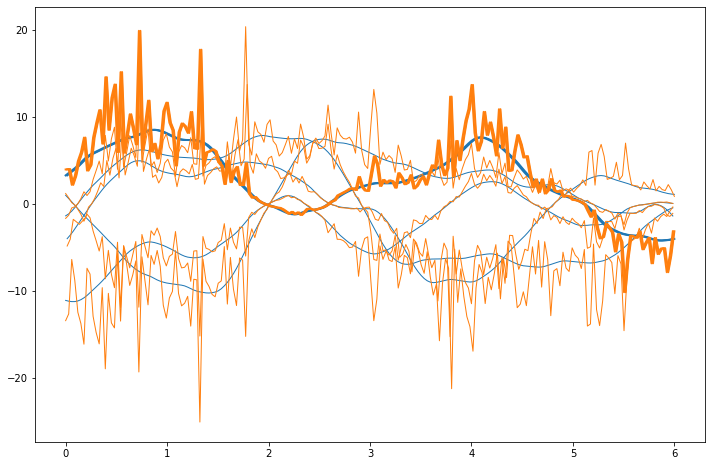

In [ ]:
plt.plot(x_grid, f_grid, "C0", linewidth=1)
_ = plt.plot(x_grid, f_grid[:, 1], "C0", linewidth=2)
_ = plt.plot(x_grid, t_samples[:, 1], "C1", linewidth=2)
_ = plt.plot(x_grid, t_samples, "C1", linewidth=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.


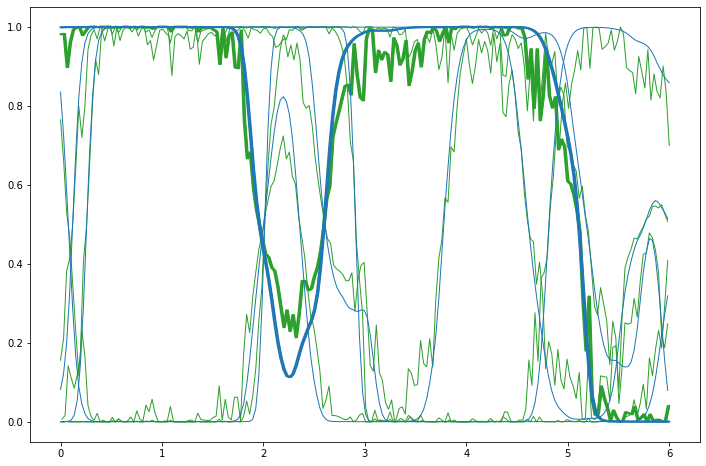

In [ ]:
def invlink(f):
    # By default, standard normal CDF is used as link function, but 
    # any other function can be used as well, just set invlink argument
    # of Bernoulli()
    return gpflow.likelihoods.Bernoulli().invlink(f).numpy()

def student_invlink(f):
    # By default, standard normal CDF is used as link function, but 
    # any other function can be used as well, just set invlink argument
    # of Bernoulli()
    return gpflow.likelihoods.Bernoulli(invlink=tf.math.sigmoid) \
                 .invlink(f).numpy()

p_grid = student_invlink(t_samples)
plt.plot(x_grid, p_grid, "C2", linewidth=1)
_ = plt.plot(x_grid, p_grid[:, 1], "C2", linewidth=2)

p_grid = invlink(f_grid)
plt.plot(x_grid, p_grid, "C0", linewidth=1)
_ = plt.plot(x_grid, p_grid[:, 1], "C0", linewidth=2)

In [ ]:
tf.

In [ ]:
tf.multiply(scaler, x_grid)

InvalidArgumentError: ignored

In [ ]:
nu = 2


tf.sqrt(nu/chi2.sample(sample_shape=x_grid.shape[0]))



<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([ 1.3007921 ,  0.5945616 ,  4.140359  ,  0.5236784 ,  1.0546414 ,
        2.3277607 ,  0.6428949 ,  0.87101114,  2.139834  ,  1.0765688 ,
        0.48967543,  0.83307487,  1.4357847 ,  0.84297323,  1.4021976 ,
        2.0693488 ,  0.7149594 ,  2.031121  ,  0.90849364,  1.0859494 ,
        1.3602829 ,  1.5546957 ,  1.1186092 ,  2.6291556 ,  1.5865874 ,
        1.2005293 ,  3.746406  ,  1.9046172 ,  0.9871173 ,  1.5947839 ,
        1.053179  ,  2.8627064 ,  3.998484  ,  0.9493354 ,  2.3621824 ,
        0.5116686 ,  1.1282829 ,  1.2950402 ,  2.1322181 ,  0.9792082 ,
        2.082827  ,  0.55384165,  1.8508312 ,  3.751865  ,  8.078958  ,
        0.9400194 ,  1.6236022 ,  8.167329  ,  0.4386076 ,  0.9109911 ,
        1.3400762 ,  1.1491632 ,  0.63242054,  1.521914  ,  1.314498  ,
        0.592963  ,  0.6141043 ,  2.804778  ,  0.6605994 ,  0.9502515 ,
        0.7335708 ,  1.1584921 ,  0.72806495,  4.295151  ,  1.6300067 ,
        3.666576

### TPC t-Laplace Approximation

In [1]:
! pip install gpflow

     |████████████████████████████████| 276kB 3.9MB/s 


In [22]:
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

plt.rcParams["figure.figsize"] = (12, 8)

tf.__version__

PI = tf.constant(np.pi, dtype=tf.float32)
obs_dist = gpflow.likelihoods.Bernoulli(invlink=tf.math.sigmoid)

def get_t(nu, nobs):
  return 2/(nu + nobs) + 1

def log_t(x, t):
  if t == 1:
    return tf.math.log(x)
  else:
    one_min_t = 1 - t
    return (x**one_min_t - 1) / one_min_t

def get_psi(t, nu, nobs, half_log_det_X):
  psi = (1. - t)*(
      tf.math.lgamma((nu + nobs)/2.) 
      - nobs/2 * (PI*nu)
      - tf.math.lgamma(nu/2.)
      - half_log_det_X
  )
  return tf.exp(psi)

#log_t approximation to posterior
def tpc_posterior(f, y, K, nu, t):
  nobs = K.shape[0]
  
  pad_K = K + 10e-5*tf.eye(nobs)
  chol_K = tf.linalg.cholesky(pad_K)
  half_log_det_K = tf.math.log(tf.reduce_sum(tf.linalg.diag_part(chol_K)))
  
  fK = tf.linalg.cholesky_solve(chol_K, f)
  
  psi = get_psi(t, nu, nobs, half_log_det_K)
  one_min_t_div = 1/(1-t)

  psi_div = psi * one_min_t_div

  ll = (
    tf.reduce_sum(log_t(tf.exp(obs_dist.log_prob(f, y)), t))
    + psi_div
    + psi_div*(1/nu)*tf.matmul(fK, fK, transpose_a=True)
    - one_min_t_div
  )

  return ll#, tf.reduce_sum(log_t(tf.exp(obs_dist.log_prob(f, y)), t)), psi_div, psi_div*(1/nu), tf.matmul(fK, fK, transpose_a=True), one_min_t_div

def compute_posterior_covariance(K, w):
  sqrt_w = tf.sqrt(w)
  sqrt_w_t = tf.reshape(sqrt_w, shape=(-1, 1))

  K_sqrt_w = tf.multiply(K, sqrt_w)
  B = tf.eye(K.shape[0]) + tf.multiply(sqrt_w_t, K_sqrt_w)
  
  chol_B = tf.linalg.cholesky(B)
  K_sqrt_w_t = tf.transpose(K_sqrt_w)
  inv_sqrt_B_sqrt_w_K = tf.linalg.cholesky_solve(chol_B, K_sqrt_w_t)

  cov_mat = K - tf.matmul(
      inv_sqrt_B_sqrt_w_K, inv_sqrt_B_sqrt_w_K, transpose_a=True)
  
  return cov_mat

def compute_hess_vec_obs_ll(f, y):
  prod_vector = tf.repeat(1., repeats=f.shape[0])
  prod_vector = tf.reshape(prod_vector, shape=(-1,1))

  with tf.autodiff.ForwardAccumulator(
      f, prod_vector) as acc:
    with tf.GradientTape() as tape:
      obs_ll = tf.reduce_sum(obs_dist.log_prob(f, y))
    grad_obs_ll = tape.gradient(obs_ll, f)

  hess_vec = acc.jvp(grad_obs_ll)
  return tf.squeeze(hess_vec)

def compute_marginal_ll(f, y, K, hess_diag):
  sqrt_w = tf.sqrt(-hess_diag)
  sqrt_w_t = tf.reshape(sqrt_w, shape=(-1, 1))

  K_sqrt_w = tf.multiply(K, sqrt_w)
  B = tf.eye(K.shape[0]) + tf.multiply(sqrt_w_t, K_sqrt_w)
  chol_B = tf.linalg.cholesky(B)

  chol_K = tf.linalg.cholesky(K  + 10e-5*tf.eye(K.shape[0]))
  inv_chol_K_f = tf.linalg.cholesky_solve(chol_K, f)

  mll = (
      - 0.5*tf.tensordot(inv_chol_K_f, inv_chol_K_f, axes=(0, 0))
      + tf.reduce_sum(obs_dist.log_prob(f, y))
      - tf.reduce_sum(tf.math.log(tf.linalg.diag_part(chol_B)))
  )
  
  return mll

k = gpflow.kernels.SquaredExponential(lengthscales=1, variance=2.)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)

L = np.linalg.cholesky(K + 10e-6*np.eye(K.shape[0]))
f = np.dot(L, rng.randn(200, 1))
f = tf.cast(f, tf.float32)
f = tf.Variable(f)

pvals = obs_dist.invlink(f)
y = tf.cast(rng.binomial(1, pvals), tf.int32)

In [23]:
get_t(nu, nobs)

<tf.Tensor: shape=(), dtype=float32, numpy=1.009901>

In [24]:
x_grid_tf = tf.constant(x_grid, dtype=tf.float64)
K = tf.cast(k(x_grid_tf), dtype=tf.float32)

nu = tf.constant(2.)
nobs = K.shape[0]

tpc_posterior(f, y, K, nu=2.0, t=get_t(nu, nobs))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.27208744e+08]], dtype=float32)>

In [25]:
### Optimize posterior
from gpflow.optimizers import NaturalGradient
from gpflow.optimizers import Scipy

opt = Scipy()

neg_post = []
marg_ll = []

x_grid_tf = tf.constant(x_grid, dtype=tf.float64)
K = tf.cast(k(x_grid_tf), dtype=tf.float32)

nu = tf.constant(2.)
nobs = K.shape[0]
t = get_t(nu, nobs)

for i in range(10):
  opt_res = opt.minimize(lambda: -tpc_posterior(f, y, K, nu, t), variables=[f])
  neg_post.append(opt_res.fun[0, 0])
  
  hess_diag = compute_hess_vec_obs_ll(f, y)

  opt_res = opt.minimize(
      lambda: -compute_marginal_ll(f, y, tf.cast(k(x_grid), tf.float32), hess_diag), 
      variables=k.trainable_variables)
  marg_ll.append(opt_res.fun[0, 0])
  print(i, 'mll', opt_res.fun[0,0])

0 mll 135.56198120117188
1 mll 135.56207275390625
2 mll 135.56207275390625
3 mll 135.56207275390625
4 mll 135.56207275390625
5 mll 135.56210327148438
6 mll 135.56202697753906
7 mll 135.56202697753906
8 mll 135.56202697753906
9 mll 135.56202697753906


In [26]:
neg_post

[1709.833251953125,
 1709.81103515625,
 1709.81103515625,
 1709.81103515625,
 1709.81103515625,
 1709.81103515625,
 1709.81103515625,
 1709.81103515625,
 1709.81103515625,
 1709.81103515625]